### Full Name : Ehsan Merrikhi
### Student Number : 400101967


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
def explore_data(data_loader):
    # Get a batch of data
    images, labels = next(iter(data_loader))

    # Plot sample images
    fig, axes = plt.subplots(1, 6, figsize=(12, 4))
    for i in range(6):  # Displaying first 6 images
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')  # MNIST images are single-channel, so squeeze removes extra dim
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()

    # Plot label distribution
    labels_np = labels.numpy()
    unique_labels, counts = np.unique(labels_np, return_counts=True)

    plt.bar(unique_labels, counts, tick_label=unique_labels)
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Label Distribution in the Batch')
    plt.show()


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 87.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 27.5MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 103MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



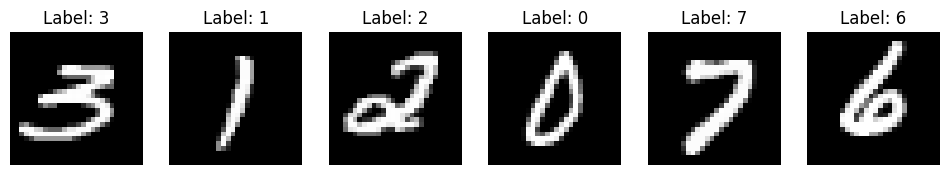

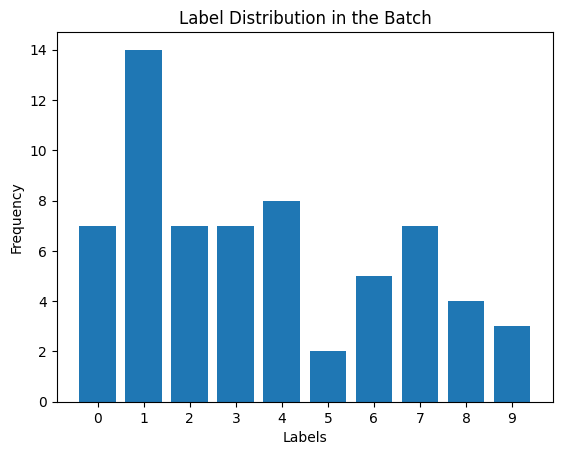

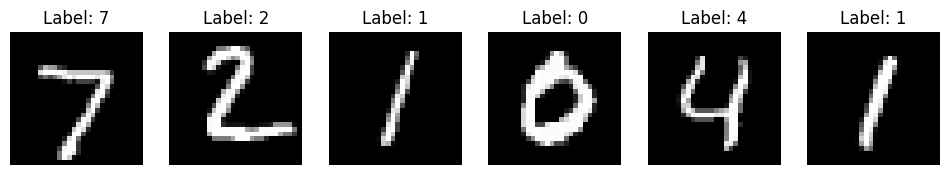

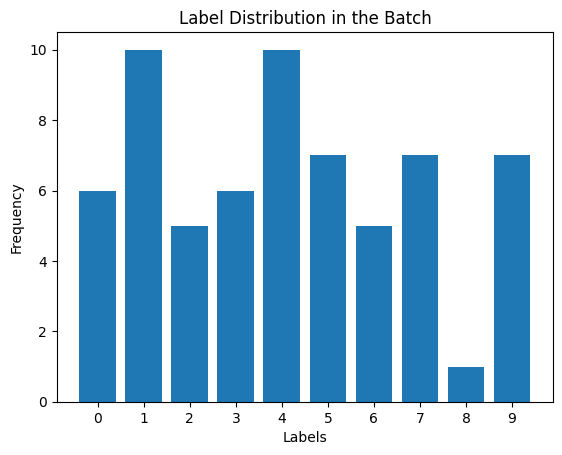

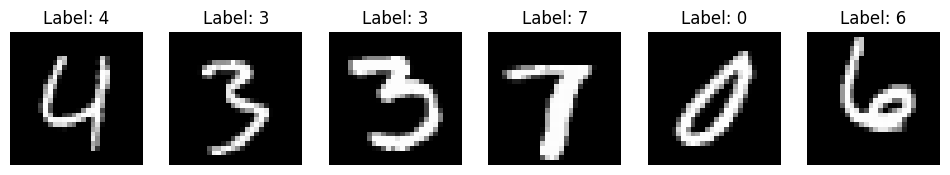

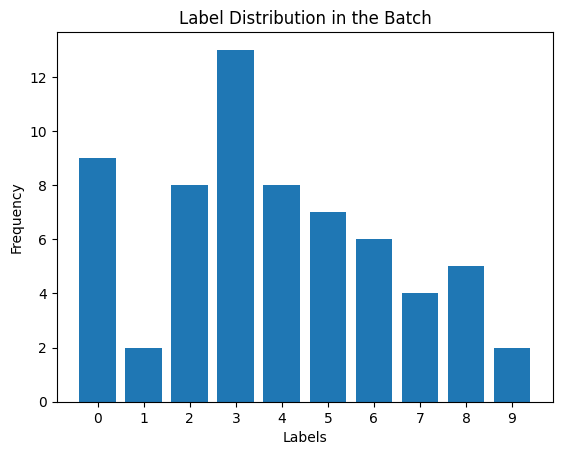

In [ ]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [ ]:
def prepare_data_for_cart(data_loader):
    X, y = [], []

    # Iterate over the data loader and collect all the images and labels
    for images, labels in data_loader:
        # Flatten the images (MNIST images are 28x28, so we flatten them to 784)
        images = images.view(images.size(0), -1)  # Reshape images to (batch_size, 784)

        # Convert the images and labels to numpy arrays and append them to X and y
        X.append(images.numpy())
        y.append(labels.numpy())

    # Convert the lists to numpy arrays
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)

    return X, y

In [ ]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

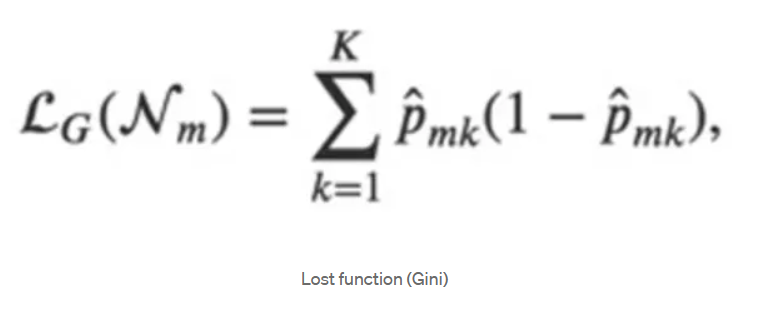

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1 or len(y) < self.min_samples_split or depth >= self.max_depth:
            # If all labels are the same, or if the data size is too small, or max depth reached
            return Node(value=np.bincount(y).argmax())

        # Find the best split
        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return Node(value=np.bincount(y).argmax())

        # Split the data
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._build_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._build_tree(X[right_idxs], y[right_idxs], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _find_best_split(self, X, y):
        best_gini = float('inf')
        best_feature, best_threshold = None, None
        n_features = X.shape[1]

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gini = self._calculate_gini_for_split(X[:, feature_idx], y, threshold)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini_impurity(self, y):
        proportions = np.bincount(y) / len(y)
        return 1 - np.sum(proportions ** 2)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])


    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _split(self, feature_column, threshold):
        left_idxs = np.argwhere(feature_column <= threshold).flatten()
        right_idxs = np.argwhere(feature_column > threshold).flatten()
        return left_idxs, right_idxs

    def _calculate_gini_for_split(self, feature_values, y, threshold):
        left_idxs = feature_values <= threshold
        right_idxs = feature_values > threshold
        if len(y[left_idxs]) == 0 or len(y[right_idxs]) == 0:
            return float('inf')

        left_gini = self._gini_impurity(y[left_idxs])
        right_gini = self._gini_impurity(y[right_idxs])
        weighted_gini = (len(y[left_idxs]) * left_gini + len(y[right_idxs]) * right_gini) / len(y)
        return weighted_gini



## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Prepare data only once for both models
X_train, y_train = prepare_data_for_cart(train_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

# Function to evaluate CART models for varying depths
def evaluate_cart_models(X_train, y_train, X_test, y_test, depths):
    cart_accuracies = []
    sklearn_accuracies = []

    # Loop through the range of depths
    for depth in depths:
        # Custom CART implementation
        tree = DecisionTree_CART(max_depth=depth)
        tree.fit(X_train, y_train)
        predictions = tree.predict(X_test)
        acc = accuracy_score(y_test, predictions)
        cart_accuracies.append(acc)

        # Scikit-learn's DecisionTreeClassifier
        sklearn_tree = DecisionTreeClassifier(max_depth=depth)
        sklearn_tree.fit(X_train, y_train)
        sklearn_predictions = sklearn_tree.predict(X_test)
        acc = accuracy_score(y_test, sklearn_predictions)
        sklearn_accuracies.append(acc)

    return cart_accuracies, sklearn_accuracies

# Range of depths to evaluate
depths = list(range(1, 11))

# Evaluate both models
cart_accuracies, sklearn_accuracies = evaluate_cart_models(X_train, y_train, X_test, y_test, depths)


Performance of both custom and scikit-learn model are the same though they are way different in computation power consumption.



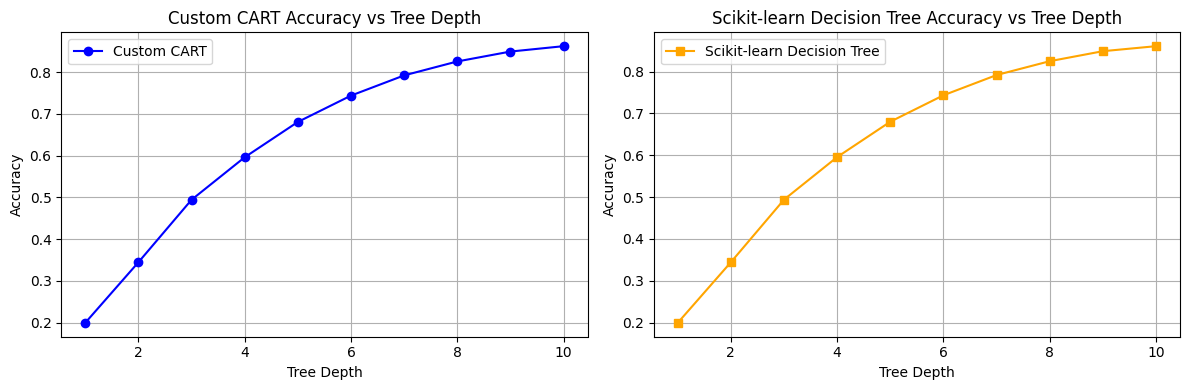

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

print('Performance of both custom and scikit-learn model are the same though they are way different in computation power consumption.\n')
# First subplot for Custom CART
axes[0].plot(depths, cart_accuracies, label='Custom CART', marker='o', color='blue')
axes[0].set_xlabel('Tree Depth')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Custom CART Accuracy vs Tree Depth')
axes[0].legend()
axes[0].grid(True)

# Second subplot for Scikit-learn Decision Tree
axes[1].plot(depths, sklearn_accuracies, label='Scikit-learn Decision Tree', marker='s', color='orange')
axes[1].set_xlabel('Tree Depth')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Scikit-learn Decision Tree Accuracy vs Tree Depth')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Question
What is the difference between ID3 and CART algorithm


## Answer
The main differences between the ID3 (Iterative Dichotomiser 3) algorithm and the CART (Classification and Regression Trees) algorithm are as follows:

1. Splitting Criterion:
ID3: Uses information gain (based on entropy) as the splitting criterion. Information gain measures the reduction in entropy (disorder) when the dataset is split based on a particular feature.
CART: Uses Gini impurity (for classification tasks) as the splitting criterion. Gini impurity measures the likelihood of a randomly chosen element being incorrectly classified.
2. Tree Type:
ID3: Only works for classification tasks and builds categorical decision trees.
CART: Can handle both classification and regression tasks. For regression, CART uses the mean squared error as the splitting criterion and builds regression trees.
3. Output:
ID3: Produces a multiway tree, where splits can lead to multiple child nodes based on the number of unique values in the feature.
CART: Produces a binary tree, meaning that each internal node always has two children (left and right). It splits the data into two groups at every node, regardless of the number of feature values.
4. Handling Continuous Variables:
ID3: Originally designed to handle categorical data. For continuous variables, the data needs to be discretized before using ID3.
CART: Handles both continuous and categorical variables natively by finding optimal split points for continuous features.
5. Pruning:
ID3: Does not include a pruning mechanism as part of the algorithm, though it can be added manually (e.g., post-pruning techniques).
CART: Built with a pruning mechanism (usually cost-complexity pruning) that simplifies the tree by removing branches that do not significantly improve predictive accuracy, thus preventing overfitting.
Summary:
ID3 focuses solely on classification using information gain and builds multiway trees.
CART is more versatile, supporting both classification and regression, using Gini impurity for classification and handling continuous features, while always producing binary trees.
These differences affect the types of problems each algorithm is best suited for and how they approach the task of building decision trees.